<center>
    <img src="Assets/FPT_Logo.png" alt="University Logo" width="500" style="display: flex; justify-content: center;">
</center>
<br><br><br>
<div style="border-left: 5px solid #39A7FF;">
    <h3 style="color: #39A7FF; text-align: left; font-family: 'Lucida Sans'; margin-left: 15px;">FACULTE POLYDISCIPLINAIRE – TAROUDANT</h3>
    <h1 style="color: #FA7070; text-align: left; font-family: 'Lucida Sans'; font-size: 50px; margin-left: 15px;">Image Processing– TP - Exam</h1>
    <h4 style="text-align: left; font-family: 'Lucida Sans'; margin-left: 15px;">Master – Big Data et Intelligence Artificielle (BDIA)</h4>
    <h4 style="text-align: left; font-family: 'Lucida Sans'; margin-left: 15px;">Département : GI</h4>
    <h4 style="text-align: left; font-family: 'Lucida Sans'; margin-left: 15px;">Option : BDIA (S1)</h4>
    <h4 style="text-align: left; font-family: 'Lucida Sans'; margin-left: 15px;">A.U : 2023 - 2024</h4>
</div>
<div style="height: 150px;"></div>
<h4 style="text-align: left; font-family: 'Lucida Sans';">Adil Alami</h4>
<h4 style="text-align: left; font-family: 'Lucida Sans';">27-02-2024</h4>
</br>
</br>
</br>
</br>
</br>

### Installation

> **First:** create a virtual envirenement using venv or anaconda.
 ```bash 
    # venv
    python -m venv fatigue-detection-env
    # anaconda
    conda create --name fatigue-detection-env python=3.9
 ```

 > **Second:** activate it (venv).
 ```bash 
    # fatigue-detection-env / windows
    venv\Scripts\activate
    # fatigue-detection-env / linux
    source fatigue-detection-env/bin/activate
 ```
 > **Second:** activate it (anaconda).

 ```bash
    conda activate fatigue-detection-env
 ```

 > **Third:** Install The dipendencies.
   ```bash 
   pip  install dlib_installation/dlib-19.22.99-cp39-cp39-win_amd64.whl
   pip install -r requirements.txt
   ```


<h1 style="color: #FF8F8F; text-align:center; font-family: 'Lucida Sans'; font-size: 50px;">I. Introduction</h1>

<p style=" margin-right: 50px; text-align: justify; font-family: 'Lucida Sans';">
Fatigue is a common problem among students, especially in long and intensive learning sessions. It can affect their performance, concentration, and well-being. Therefore, it is important to monitor and prevent fatigue in the classroom. In this project, we propose a system that can detect fatigue among students using cameras and a metric called eye aspect ratio (EAR). EAR is a measure of eye openness, calculated from the positions of six facial landmarks around the eye. A low EAR indicates that the eye is closed, while a high EAR indicates that the eye is open. By tracking the EAR values over time, we can determine the duration of eye closure, which is an indicator of fatigue. We aim to set a minimum threshold for EAR and alert the teacher or the supervisor when the fatigue is detected for a prolonged period. This system can help to improve the safety and the quality of learning in the classroom.
</p>


<div style="display: flex; flex-direction: row; justify-content: center;">
    <img src="assets/open_annot.png" alt="Opened eyes" width="800" style="margin: 10px;">
    <img src="assets/close_annot.png" alt="Closed eyes" width="800" style="margin: 10px;">
</div>

<p style="margin-right: 50px; text-align: justify; font-family: 'Lucida Sans';">
To implement this system, we will follow the steps outlined in the web page context. First, we will extract the images from a video of a learning session. Then, we will convert the images to grayscale and apply some noise removal and quality enhancement techniques. Next, we will use edge detection methods such as Canny or Sobel to find the contours of the eyes. After that, we will apply some morphological operations to refine the contours and segment the eyes. Then, we will use a facial landmark detector to locate the six points of interest (p1, …, p6) around each eye. The EAR is calculated from the formula:
</p>

$$
    EAR = \frac{||p1 - p4|| + ||p3 - p5||}{2 ||p1 - p4||}
$$

<p style="margin-right: 50px; text-align: justify; font-family: 'Lucida Sans';">
where ∣∣⋅∣∣ denotes the Euclidean distance between two points. At each time instant t (e.g., t = 10s), we will compute the EAR and save it in a CSV file3. Finally, we will analyze the EAR data to detect the periods of prolonged fatigue. We will define some fatigue thresholds based on the EAR values and set up an alert mechanism to signal the moments when the fatigue is detected for a long time. This alert can be a visual or auditory notification for the teacher or the supervisor, so that they can take appropriate actions to ensure the safety and well-being of the students.
</p>

<h1 style="color: #FF8F8F; text-align:center; font-family: 'Lucida Sans'; font-size: 50px;">II. Required libraries</h1>

In [21]:
# Import necessary modules
import cv2
from scipy.spatial import distance
import dlib
from imutils import face_utils
import numpy as np
import csv
import pygame
from datetime import datetime
import os
from threading import Thread
import matplotlib.pyplot as plt
import pandas as pd

1. ``cv2`` (OpenCV): OpenCV is a popular computer vision library. It provides various functions and algorithms for image and video processing. In this project, OpenCV is used for tasks such as capturing video from the camera, extracting frames, performing image processing operations, and drawing on frame.

2. ``scipy.spatial.distance``: This module from the SciPy library provides functions for calculating distances between points or sets of points. It is used in this project to calculate the distance between facial landmarks detected by the dlib library.

3. ``dlib``: Dlib is a powerful library for machine learning and computer vision tasks. It provides a wide range of functionalities, including face detection, facial landmark detection, and shape prediction. In this project, ``dlib`` is used to detect facial landmarks, which are specific points on the face such as the corners of the eyes.

    * We also utilised a pre trained frontal face detector from Dlib’s library which is based on a modification to the Histogram of Oriented Gradients in combination with Linear SVM for classification. 

    * The pre-trained facial landmark detector ``shape_predictor_68_face_landmarks.dat`` is used to estimate the location of 68 (x, y)-coordinates that map to facial structures on the face. The 68 landmark output is shown in the figure below.

<center><img src="assets/face_landmarks.jpg" alt="face landmarks" width="400"></center>

4. ``imutils.face_utils``: This module from the ``imutils`` library provides utility functions for working with facial landmarks. It includes functions for extracting specific facial features, such as the eyes, eyebrows, and mouth, from the detected landmarks, it is used in this project to detect the leaft and right eye.

5. ``numpy``: NumPy is a fundamental library for numerical computing in Python. It provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays efficiently. In this project, ``numpy`` is used for array manipulation and mathematical calculations, such as calculating distances between facial landmarks.

6. ``csv``: The csv module is a built-in Python module that provides functionality for reading and writing CSV (Comma-Separated Values) files. In this project, it's used for saving the EAR values with timestamps to a CSV file for further analysis and visualization.

7. ``pygame``: Pygame is a cross-platform set of Python modules designed for creating video games. It provides functionality for handling multimedia resources, such as sound and graphics. In this project, ``pygame`` is used to play an alert sound when certain conditions are met.

8. ``datetime``: The datetime module is a built-in Python module that provides classes for working with dates and times. In this project, it's used for adding timestamps to the EAR values saved in the CSV file.

9. ``os``: The os module is a built-in Python module that provides a way to interact with the operating system. It provides functions for tasks such as file and directory manipulation, environment variables, and process management. In this project, it is used here for creating directories to save processed frames and checking file paths.

10. ``threading``: The threading module provides a high-level interface for working with threads.
Threads are used to perform processing tasks in the background while the main loop continues to capture frames and detect fatigue.

11. ``matplotlib.pyplot``: ``Matplotlib`` is a plotting library for Python and its numerical mathematics extension NumPy. It provides an object-oriented API for embedding plots into applications using general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK. The ``pyplot`` module in the ``matplotlib`` library is a collection of functions that helps in creating a variety of charts. In this project, matplotlib.pyplot is used to visualize EAR data in a graphical format.

<h1 style="color: #FF8F8F; text-align:center; font-family: 'Lucida Sans'; font-size: 50px;">III. Defining Helper Functions</h1>
<h2 style="color: #00A9FF; text-align:left; font-family: 'Lucida Sans'; font-size: 30px;">III.1. EAR calculation</h2>

In [22]:
#---------------------------------------------------------------------------
#                 Function to calculate eye aspect ratio (EAR)
#---------------------------------------------------------------------------
def eye_aspect_ratio(eye:list) -> float:
    """
    Calculate the eye aspect ratio (EAR) using the given eye landmarks.

    Parameters:
    - eye: list of tuples representing the coordinates of the eye landmarks

    Returns:
    - ear: the calculated eye aspect ratio
    """
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

This function, ``eye_aspect_ratio(eye)``, calculates the Eye Aspect Ratio (EAR), a measure used to determine whether a person’s eyes are open or closed. It takes as input a list of tuples, eye, which represent the coordinates of the eye landmarks.

* It calculates the Euclidean distance between the second and sixth landmarks of the eye, and assigns this value to A.

* It calculates the Euclidean distance between the third and fifth landmarks of the eye, and assigns this value to B.

* It calculates the Euclidean distance between the first and fourth landmarks of the eye, and assigns this value to C.

* It calculates the EAR as the average of A and B, divided by C. This is based on the formula for EAR:

$$
    EAR = \frac{||p1 - p4|| + ||p3 - p5||}{2 ||p1 - p4||}
$$

* It returns the calculated EAR.

The EAR is a ratio used for eye blink detection, where a decrease in EAR below a certain threshold indicates a blink. In our project project, it’s used to detect fatigue: if the EAR is below a certain threshold for a prolonged period (10 frames), it could indicate that the person is tired. This function is a key part of the fatigue detection system we are implementing.

<h2 style="color: #00A9FF; text-align:left; font-family: 'Lucida Sans'; font-size: 30px;">III.2. Save EAR Values</h2>

In [23]:
#---------------------------------------------------------------------------
#           Function to save EAR values with timestamps to CSV
#---------------------------------------------------------------------------

def save_ear_values(ear_values:list, frame_count:int, threshold:float=0.25) -> None:
    """
    Saves the EAR (Eye Aspect Ratio) values to a CSV file.

    Args:
        ear_values (list): List of EAR values.
        frame_count (int): Current frame count.

    Returns:
        None
    """
    if ear_values:
        if frame_count % 10 == 0:
            timestamp = datetime.now().strftime("%M:%S:%f")
            with open('output/ear_values.csv', mode='a', newline='\n') as file:
                writer = csv.writer(file)
                if file.tell() == 0:
                    writer.writerow(['time', 'EAR'])
                # writer.writerow([timestamp, ear_values[-1]])
                for ear in ear_values:  # Iterate over all EAR values
                    writer.writerow([timestamp, ear])  # Save each EAR value with the timestamp
            
            with open('output/tiredness.csv', mode='a', newline='\n') as tiredness_file:
                tiredness_writer = csv.writer(tiredness_file)
                if tiredness_file.tell() == 0:
                    tiredness_writer.writerow(['time', 'EAR'])
                
                for ear in ear_values:  # Iterate over all EAR values
                    if ear < threshold:  # Check if the EAR value is below the threshold
                        tiredness_writer.writerow([timestamp, 1])  # Save the EAR value if below the threshold
                    else:
                        tiredness_writer.writerow([timestamp, 0])  # Save 0 if the EAR value is above the threshold

This function, ``save_ear_values(ear_values, frame_count)``, is used to save the Eye Aspect Ratio (EAR) values to a CSV file. It takes two arguments: a list of EAR values (ear_values) and the current frame count (frame_count).

* It checks if the ear_values list is not empty. If it is empty, the function does nothing and returns None.

* If the ear_values list is not empty, it checks if the current frame count is a multiple of 10. This is done using the modulus operator (%). If the frame count is not a multiple of 10, the function does nothing and returns None.

* If the frame count is a multiple of 10, it gets the current time and formats it as minutes, seconds, and microseconds. This timestamp is saved in the timestamp variable.

* It opens the file output/ear_values.csv in append mode (mode='a'). If the file does not exist, it will be created.

* It creates a CSV writer object (writer) that can write rows to the CSV file.

* It checks if the file is empty (i.e., if it’s a new file). If it is, it writes a header row with the column names ‘time’ and ‘EAR’.

* It writes a new row to the CSV file with the current timestamp and the last EAR value in the ear_values list.

The function does not return any value (it returns None).
This function is used to save the EAR values at regular intervals (every 10 frames) during a video processing task.

<h2 style="color: #00A9FF; text-align:left; font-family: 'Lucida Sans'; font-size: 30px;">III.3. Process Frames</h2>

In [24]:
#---------------------------------------------------------------------------
#                         Function to process frames
#---------------------------------------------------------------------------

def process_frame(frame:np.ndarray, frame_count:int, output_dir:str) -> np.ndarray:
    """
    Process a frame by performing various image processing techniques and saving the processed frames into respective directories.

    Args:
        frame (numpy.ndarray): The input frame to be processed.
        frame_count (int): The count of the current frame.
        output_dir (str): The directory where the processed frames will be saved.

    Returns:
        numpy.ndarray: The processed frame in grayscale.

    """
    
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Noise reduction using bilateral filter
    blurred = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # Histogram equalization for enhancing contrast
    equalized = cv2.equalizeHist(gray)
    
    # Edge detection using Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    edges = cv2.sqrt(cv2.addWeighted(cv2.pow(sobelx, 2), 1.0, cv2.pow(sobely, 2), 1.0, 0))
    edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    # Morphology techniques (Closing operation to close gaps between edges)
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    # Improve contrast using OpenCV convertScaleAbs
    contrasted = cv2.convertScaleAbs(gray, alpha=1.5, beta=0)
    
    # Save processed frames into respective directories
    cv2.imwrite(os.path.join(output_dir, 'original', f'frame-{frame_count}.jpg'), frame)
    cv2.imwrite(os.path.join(output_dir, 'sobel', f'frame-{frame_count}.jpg'), edges)
    cv2.imwrite(os.path.join(output_dir, 'grey', f'frame-{frame_count}.jpg'), gray)
    cv2.imwrite(os.path.join(output_dir, 'morphology', f'frame-{frame_count}.jpg'), closing)
    cv2.imwrite(os.path.join(output_dir, 'noise_reduction', f'frame-{frame_count}.jpg'), blurred)
    cv2.imwrite(os.path.join(output_dir, 'hist_equilization', f'frame-{frame_count}.jpg'), equalized)
    cv2.imwrite(os.path.join(output_dir, 'contrast_improv', f'frame-{frame_count}.jpg'), contrasted)
    
    return gray

<h2 style="color: #00A9FF; text-align:left; font-family: 'Lucida Sans'; font-size: 30px;">III.4. Plot EAR Values</h2>

In [25]:
#---------------------------------------------------------------------------
#                        Function to plot the EAR Values
#---------------------------------------------------------------------------

def plot_ear_values(ear_df:pd.DataFrame, tire_df:pd.DataFrame) -> None:
    """
    Plot the EAR values over time.

    Args:
        ear_df (pd.DataFrame): DataFrame containing the raw EAR values.
        tire_df (pd.DataFrame): DataFrame containing the tiredness EAR values.
    """
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 10), sharex=True)
    plt.style.use('dark_background')

    # Plot raw EAR values
    ax1.plot(range(len(ear_df['EAR'])), ear_df['EAR'], label='Raw EAR')
    ax1.set_ylabel("Ear Value")
    ax1.set_title("Raw EAR Values Over Time")
    ax1.axhline(y=0.25, color='r', linestyle='--')
    ax1.legend()

    # Plot raw EAR values with color fill
    ax2.plot(range(len(ear_df['EAR'])), ear_df['EAR'], label='Raw EAR')
    ax2.fill_between(range(len(ear_df['EAR'])), ear_df['EAR'], where=ear_df['EAR'] < 0.25, color='red', alpha=0.5)
    ax2.fill_between(range(len(ear_df['EAR'])), ear_df['EAR'], where=ear_df['EAR'] >= 0.25, color='green', alpha=0.5)
    ax2.set_ylabel("Ear Value")
    ax2.set_title("Raw EAR Values Over Time")
    ax2.axhline(y=0.25, color='r', linestyle='--')
    ax2.legend()

    # Plot tiredness EAR values
    ax3.plot(range(len(tire_df['EAR'])), tire_df['EAR'], label='Tiredness EAR')
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Ear Value")
    ax3.set_title("Tiredness EAR Values Over Time")
    ax3.axhline(y=0.25, color='r', linestyle='--')
    ax3.legend()

    # Display the subplots
    plt.show()


<h1 style="color: #FF8F8F; text-align:center; font-family: 'Lucida Sans'; font-size: 50px;">IV. Initialization and Configuration</h1>

In [26]:
#---------------------------------------------------------------------------
#  *                                 INFO
#    This script initializes variables, loads face detector and landmark predictor,
#    creates output directories, opens a video file, and initializes other variables.
#---------------------------------------------------------------------------

# Initialize pygame mixer for playing audio and Load the alert sound
pygame.mixer.init()
alert_sound = pygame.mixer.Sound("audio/wake_up.wav")

# Initialize variables
ear_values = []
frame_count = 0
frame_count_2 = 0
alert_count = 0
exit_flag = False


# Load face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")
danger_image = cv2.imread("assets/danger.png")

# Indices of facial landmarks for left and right eyes
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

# Create output directories if they don't exist
output_dir = 'output'
os.makedirs(os.path.join(output_dir, 'original'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'sobel'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'grey'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'morphology'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'noise_reduction'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'hist_equilization'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'contrast_improv'), exist_ok=True)

# Open the video file
# 0 for live camera or path for exesting video
cap = cv2.VideoCapture("videos/video3.MOV")

width = 1080
cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize variables
fps = cap.get(cv2.CAP_PROP_FPS)
interval = int(fps) * 1  # Extract frame every 1 second

# Create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'avc1')
output_video = cv2.VideoWriter('output/output_video.mp4', fourcc, 20.0, (original_width, original_height))

<h1 style="color: #FF8F8F; text-align:center; font-family: 'Lucida Sans'; font-size: 50px;">V. Frame Processing and Saving Thread</h1>

In [27]:
#---------------------------------------------------------------------------
#    Function to process frames and save processed frames every 1 second
#---------------------------------------------------------------------------

def process_frames_and_save() -> None:
    """
    Process frames from a video capture and save them to an output directory.
    
    This function reads frames from a video capture object and processes them using the process_frame function.
    The processed frames are then saved to the specified output directory.
    The function exits when the video capture is no longer opened or the exit_flag is set to True.
    The exit_flag can be set to True by pressing the 'q' key.
    """
    global frame_count, exit_flag  # Declare frame_count and exit_flag as global
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or exit_flag:  # Exit loop if not ret or exit_flag is True
            break
        
        frame_count += 1
        
        if frame_count % interval == 0:
            processed_frame = process_frame(frame, frame_count, output_dir)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

# Start a thread for processing frames and saving processed frames
processing_thread = Thread(target=process_frames_and_save)
processing_thread.start()


<h1 style="color: #FF8F8F; text-align:center; font-family: 'Lucida Sans'; font-size: 50px;">VI. Fatigue Detection and Alert</h1>

In [28]:
#---------------------------------------------------------------------------
#                         Start detecting tiredness
#---------------------------------------------------------------------------

cap = cv2.VideoCapture("videos/video3.MOV")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    subjects = detector(gray, 0)

    # Loop over detected faces
    for subject in subjects:
        # Detect facial landmarks
        shape = predictor(gray, subject)
        shape = face_utils.shape_to_np(shape)

        # Extract left and right eye coordinates
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]

        # Calculate EAR for each eye
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)

        # Average EAR of both eyes
        ear = (leftEAR + rightEAR) / 2.0
        ear_values.append(ear)
        
        # Draw eyes contours
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 255), 1)  # Yellow color
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 255), 1)  # Yellow color

        # Draw eyes on the frame
        for (x, y) in leftEye:
            cv2.circle(frame, (x, y), 2, (0, 0, 255), -1)
        for (x, y) in rightEye:
            cv2.circle(frame, (x, y), 2, (0, 0, 255), -1)

        # Connect landmarks with lines
        cv2.line(frame, tuple(leftEye[1]), tuple(leftEye[5]), (0, 255, 0), 1)
        cv2.line(frame, tuple(leftEye[2]), tuple(leftEye[4]), (0, 255, 0), 1)
        cv2.line(frame, tuple(leftEye[0]), tuple(leftEye[3]), (0, 255, 0), 1)
        cv2.line(frame, tuple(rightEye[1]), tuple(rightEye[5]), (0, 255, 0), 1)
        cv2.line(frame, tuple(rightEye[2]), tuple(rightEye[4]), (0, 255, 0), 1)
        cv2.line(frame, tuple(rightEye[0]), tuple(rightEye[3]), (0, 255, 0), 1)

        # Check if eyes are closed
        if ear < 0.25:
            alert_count += 1
            if alert_count >= 10 and not pygame.mixer.get_busy():
                # Visual alert (draw text)
                cv2.putText(frame, "ALERT! Fatigue Detected !!!", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 4)
                cv2.putText(frame, "ALERT! Fatigue Detected !!!", (frame.shape[1] - 550, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 4)

                # Display danger image on both sides
                frame[50:50 + danger_image.shape[0], 50:50 + danger_image.shape[1]] = danger_image
                frame[50:50 + danger_image.shape[0], frame.shape[1] - 50 - danger_image.shape[1]:frame.shape[1] - 50] = danger_image

                # Play sound alert
                alert_sound.play()

        else:
            alert_count = 0

    # Write the frame to the output video
    output_video.write(frame)
    
    # Display the frame (if needed)
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        exit_flag = True
        break

    # Increment frame count
    frame_count_2 += 1
    
    # Check if it's time to save EAR values to CSV
    if frame_count_2 % 10 == 0:  # Save EAR values every 10 frames
        save_ear_values(ear_values, frame_count_2)
        ear_values = []  # Clear the ear_values list
        
# Wait for the processing thread to finish
processing_thread.join()

# Release resources
cap.release()
output_video.release()
cv2.destroyAllWindows()


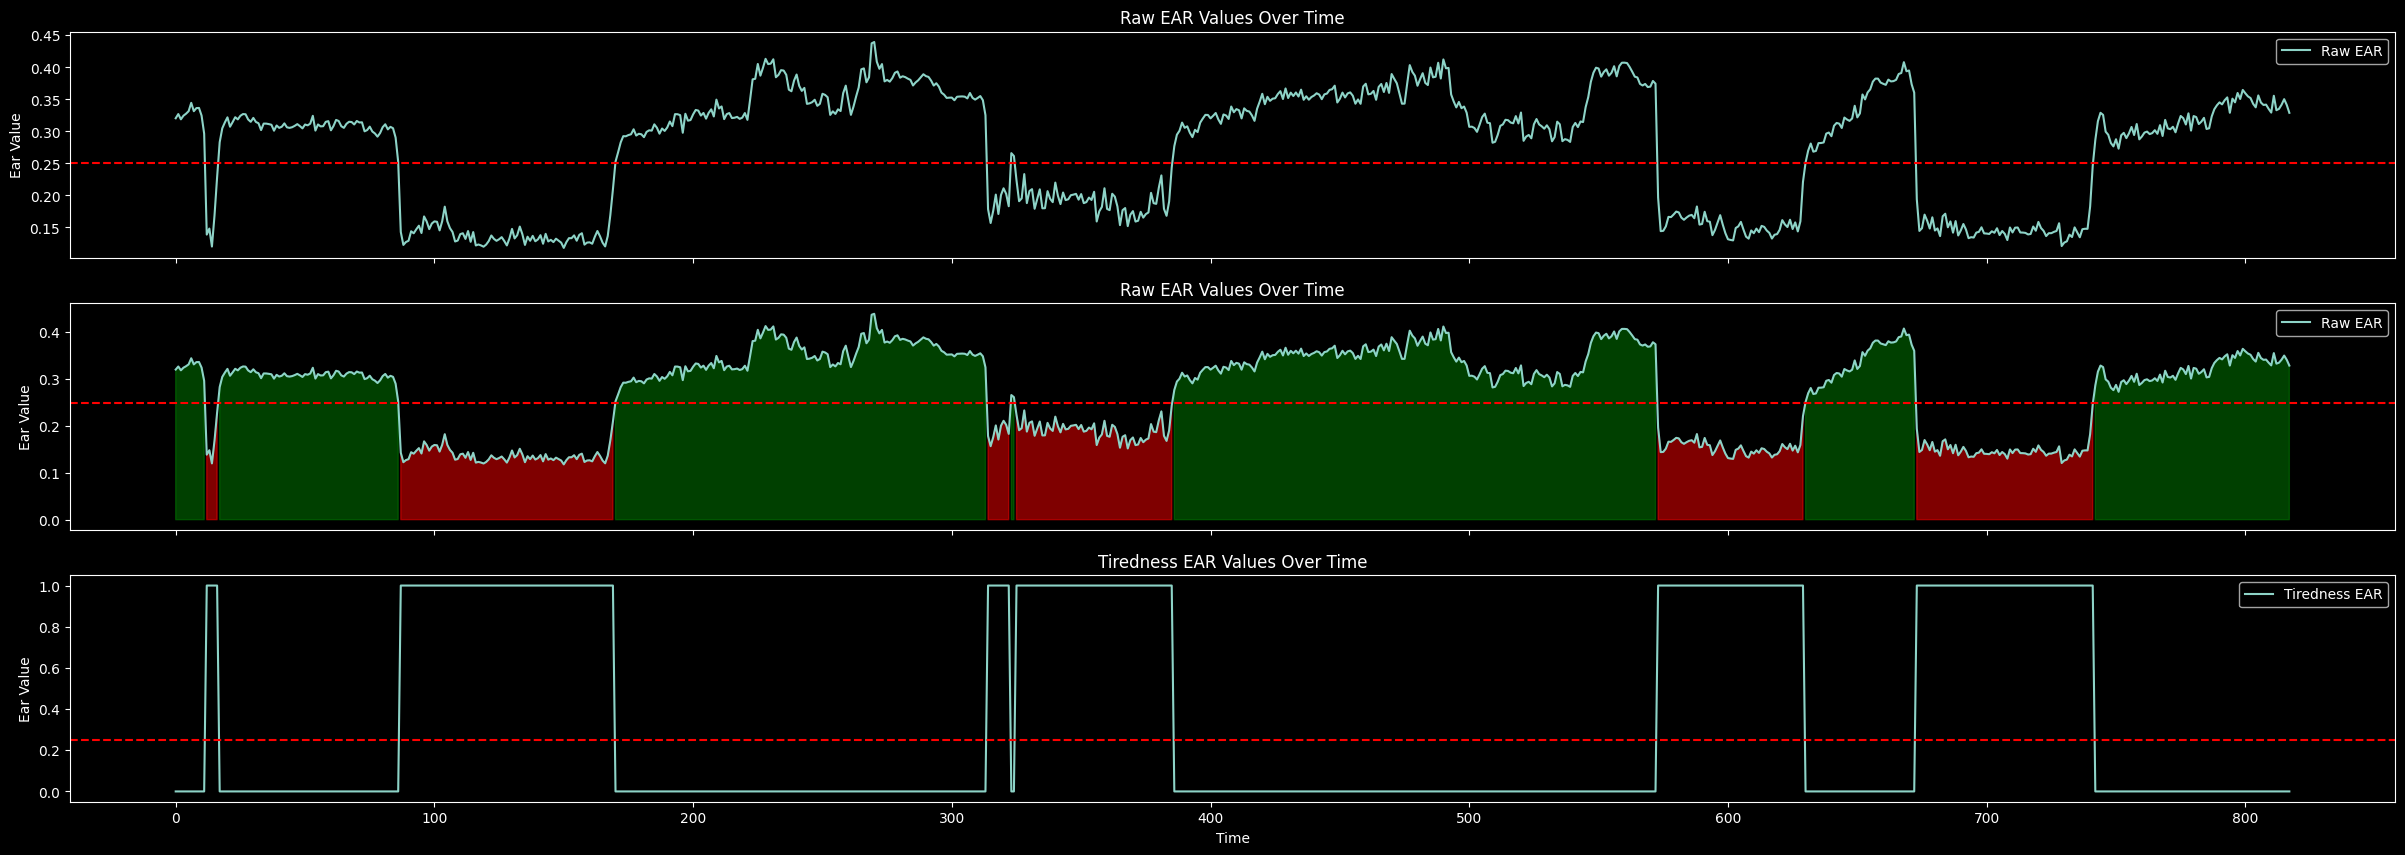

In [29]:
ear_df = pd.read_csv('output/ear_values.csv')
tire_df = pd.read_csv('output/tiredness.csv')

plot_ear_values(ear_df, tire_df)